In [1]:
import sys
!{sys.executable} -m pip install pandas matplotlib yfinance numpy google-cloud-bigquery pyarrow pandas-gbq

import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf # https://github.com/ranaroussi/yfinance
import numpy as np
from google.cloud import bigquery as bq
from google.oauth2 import service_account

  Using cached google_cloud_bigquery-2.29.0-py2.py3-none-any.whl (203 kB)
     |████████████████████████████████| 19.1 MB 2.9 MB/s eta 0:00:01
  Using cached pandas_gbq-0.15.0-py3-none-any.whl (25 kB)
  Using cached multitasking-0.0.9.tar.gz (8.1 kB)
     |████████████████████████████████| 4.6 MB 3.2 MB/s eta 0:00:01
  Using cached google_api_core-2.2.1-py2.py3-none-any.whl (95 kB)
     |████████████████████████████████| 75 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 3.1 MB/s eta 0:00:01
  Using cached pydata_google_auth-1.2.0-py2.py3-none-any.whl (13 kB)
     |████████████████████████████████| 155 kB 3.0 MB/s eta 0:00:01
  Using cached googleapis_common_protos-1.53.0-py2.py3-none-any.whl (198 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached 

In [2]:
# Import data
green_stocks = pd.read_csv('green_stocks.csv')
green_stocks.head()

,Name,Ticker,Category,ETF
0,Brookfield Renewable Partners,BEP,power_hydro,NaN
1,General Electric,GE,power_wind,NaN
2,NextEra Energy Partners,NEP,power_wind,NaN
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN
4,Vestas Wind Systems,VWDRY,power_wind,NaN


<AxesSubplot:>

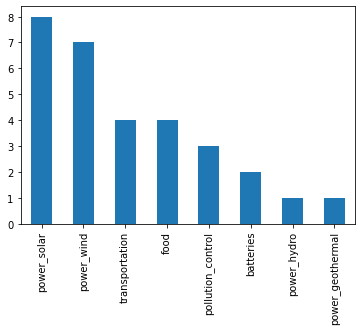

In [3]:
# Understand distribution of stock data
green_stocks['Category'].value_counts().plot(kind='bar')

<AxesSubplot:>

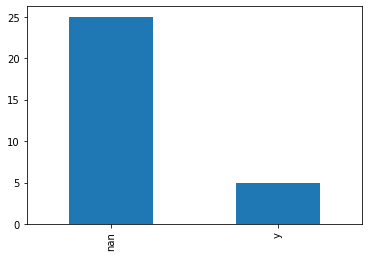

In [4]:
green_stocks['ETF'].value_counts(dropna=False).plot(kind='bar')

In [5]:
# Example Yahoo Finance query based on ticker symbol of 'BEP'
BEP = yf.Ticker('BEP')

In [6]:
BEP.info['longBusinessSummary']

'Brookfield Renewable Partners L.P. owns a portfolio of renewable power generating facilities primarily in North America, Colombia, Brazil, Europe, India, and China. The company generates electricity through hydroelectric, wind, solar, distributed generation, pumped storage, cogeneration, and biomass sources. Its portfolio consists of approximately 19,000 megawatts of installed capacity. Brookfield Renewable Partners Limited operates as the general partner of Brookfield Renewable Partners L.P. The company was formerly known as Brookfield Renewable Energy Partners L.P. and changed its name to Brookfield Renewable Partners L.P. in May 2016. Brookfield Renewable Partners L.P. was founded in 1999 and is based in Toronto, Canada.'

In [7]:
BEP.info['website']

'http://www.bep.brookfield.com'

In [8]:
# Get stock data for all green stocks

stock_descriptions = []
stock_websites = []

def get_stock_description(ticker):
    stock = yf.Ticker(ticker)
    # Descriptive information
    try:
        description = stock.info['longBusinessSummary']
        website = stock.info['website']
    except:
        description = np.nan
        website = np.nan
        print(f'No stock with {ticker} ticker symbol...')
    stock_descriptions.append(description)
    stock_websites.append(website)

In [9]:
green_stocks['Ticker'].apply(get_stock_description)

green_stocks = pd.concat([green_stocks,pd.Series(stock_descriptions, name='Description')], axis=1).copy()
green_stocks = pd.concat([green_stocks,pd.Series(stock_websites, name='Website')], axis=1).copy()

No stock with FAN ticker symbol...
No stock with VSLR ticker symbol...
No stock with TAN ticker symbol...
No stock with EVX ticker symbol...
No stock with PZD ticker symbol...
No stock with DRIV ticker symbol...


In [10]:
green_stocks

,Name,Ticker,Category,ETF,Description,Website
0,Brookfield Renewable Partners,BEP,power_hydro,NaN,Brookfield Renewable Partners L.P. owns a port...,http://www.bep.brookfield.com
1,General Electric,GE,power_wind,NaN,General Electric Company operates as a high-te...,http://www.ge.com
2,NextEra Energy Partners,NEP,power_wind,NaN,"NextEra Energy Partners, LP acquires, owns, an...",http://www.investor.nexteraenergypartners.com
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN,"Siemens Gamesa Renewable Energy, S.A., togethe...",http://www.siemensgamesa.com
4,Vestas Wind Systems,VWDRY,power_wind,NaN,"Vestas Wind Systems A/S designs, manufactures,...",http://www.vestas.com
5,First Trust Global Wind Energy ETF,FAN,power_wind,y,NaN,NaN
6,First Solar,FSLR,power_solar,NaN,"First Solar, Inc. provides photovoltaic (PV) s...",http://www.firstsolar.com
7,JinkoSolar Holding,JKS,power_solar,NaN,"JinkoSolar Holding Co., Ltd., together with it...",http://www.jinkosolar.com
8,Sunpower,SPWR,power_solar,NaN,SunPower Corporation delivers solar solutions ...,http://us.sunpower.com
9,Enphase Energy,ENPH,power_solar,NaN,"Enphase Energy, Inc., together with its subsid...",http://www.enphase.com


In [11]:
# Clean up stocks with missing description / websites (indicating no data in Yahoo Finance)
# These are mostly ETFs
green_stocks = green_stocks.dropna(subset=['Description']).copy()
green_stocks.drop(labels=['ETF'], axis=1, inplace=True)
green_stocks.head()

,Name,Ticker,Category,Description,Website
0,Brookfield Renewable Partners,BEP,power_hydro,Brookfield Renewable Partners L.P. owns a port...,http://www.bep.brookfield.com
1,General Electric,GE,power_wind,General Electric Company operates as a high-te...,http://www.ge.com
2,NextEra Energy Partners,NEP,power_wind,"NextEra Energy Partners, LP acquires, owns, an...",http://www.investor.nexteraenergypartners.com
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,"Siemens Gamesa Renewable Energy, S.A., togethe...",http://www.siemensgamesa.com
4,Vestas Wind Systems,VWDRY,power_wind,"Vestas Wind Systems A/S designs, manufactures,...",http://www.vestas.com


In [12]:
# Upload green stocks dataframe to BigQuery

# Credentials, settings
project_id, dataset, table_name = "pme-green-stocks", "pme_green_stocks", "green_stock_descriptions"

green_stocks.to_gbq( f"{dataset}.{table_name}", project_id = project_id, if_exists = 'replace')
print("Write to GBQ complete.")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=8kuWllLIRDMf0VGgYqjTqvpC8itjMj&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWiDnCVPjn6y_sDQtaUGRAslB6cPLUTpXrtaKwsxHunnMNGLHn-f004


Unable to create credentials directory.


Write to GBQ complete.


In [41]:
# Load S&P 500 open/close price data into new table for max/min dates of green stocks

def get_high_lows(ticker):
    try:
        data = yf.download(  # or pdr.get_data_yahoo(...
                # tickers list or string as well
                tickers = ticker,

                # use "period" instead of start/end
                # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                # (optional, default is '1mo')
                period = "5y",

                # fetch data by interval (including intraday if period < 60 days)
                # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                # (optional, default is '1d')
                interval = "1mo",

                # group by ticker (to access via data['SPY'])
                # (optional, default is 'column')
    #             group_by = 'ticker',

                # adjust all OHLC automatically
                # (optional, default is False)
                auto_adjust = True,

                # download pre/post regular market hours data
                # (optional, default is False)
                prepost = False,

                # use threads for mass downloading? (True/False/Integer)
                # (optional, default is True)
                threads = True,

                # proxy URL scheme use use when downloading?
                # (optional, default is None)
                proxy = None
            )
        data['Ticker'] = ticker
        return data
    except:
        print("ERROR")

stock_hl = get_high_lows("^GSPC")

[*********************100%***********************]  1 of 1 completed


In [42]:
stock_hl.tail()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2021-07-01,4300.729980,4429.970215,4233.129883,4395.259766,66496430000,^GSPC
2021-08-01,4406.859863,4537.359863,4367.729980,4522.680176,63217960000,^GSPC
2021-09-01,4528.799805,4545.850098,4305.910156,4307.540039,66268850000,^GSPC
2021-10-01,4317.160156,4608.080078,4278.939941,4605.379883,61874700000,^GSPC
2021-10-29,4572.870117,4608.080078,4567.589844,4605.379883,2346010000,^GSPC


In [43]:
for stock in green_stocks.Ticker.to_list():
    data = get_high_lows(stock)
    stock_hl = pd.concat([stock_hl, data])
    
stock_hl

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2016-11-01,2128.679932,2214.100098,2083.790039,2198.810059,8.829976e+10,^GSPC
2016-12-01,2200.169922,2277.530029,2187.439941,2238.830078,7.525124e+10,^GSPC
2017-01-01,2251.570068,2300.989990,2245.129883,2278.870117,7.048318e+10,^GSPC
2017-02-01,2285.590088,2371.540039,2271.649902,2363.639893,6.916242e+10,^GSPC
2017-03-01,2380.129883,2400.979980,2322.250000,2362.719971,8.154777e+10,^GSPC
...,...,...,...,...,...,...
2021-07-01,29.830000,30.500000,26.719999,27.900000,6.763000e+05,LSF
2021-08-01,27.920000,28.570000,17.375000,19.930000,1.674900e+06,LSF
2021-09-01,19.590000,21.150000,16.900000,19.080000,9.477000e+05,LSF


In [55]:
# Confirm which stocks contain any missing data
stock_hl.loc[stock_hl['High'].isnull(), 'Ticker'].value_counts()

BEP      23
GE       22
NEP      20
ORA      20
INGR     19
BRLXF    18
GM       14
F        13
MNHVF    11
VWDRY     6
GCTAY     2
SPWR      1
TSLA      1
FCEL      1
Name: Ticker, dtype: int64

In [58]:
# Drop rows with missing data
stock_hl = stock_hl.dropna(subset=['Open','High','Low','Close','Volume']).copy()
stock_hl.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2016-11-01,2128.679932,2214.100098,2083.790039,2198.810059,8.829976e+10,^GSPC
2016-12-01,2200.169922,2277.530029,2187.439941,2238.830078,7.525124e+10,^GSPC
2017-01-01,2251.570068,2300.989990,2245.129883,2278.870117,7.048318e+10,^GSPC
2017-02-01,2285.590088,2371.540039,2271.649902,2363.639893,6.916242e+10,^GSPC
2017-03-01,2380.129883,2400.979980,2322.250000,2362.719971,8.154777e+10,^GSPC


In [59]:
# Upload stock high/low table to BigQuery

# Credentials, settings
project_id, dataset, table_name = "pme-green-stocks", "pme_green_stocks", "high_low"

stock_hl.to_gbq( f"{dataset}.{table_name}", project_id = project_id, if_exists = 'replace')
print("Write to GBQ complete.")

Write to GBQ complete.
